In [ ]:
  import numpy as np
import pandas as pd
from sklearn.svm import SVC


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score
import scipy

%matplotlib inline

SEED = 133742069
np.random.seed(SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def load_wines(classes=2, columns=2):
  raw_wine_ds = datasets.load_wine()
  class_filter = raw_wine_ds.target < classes

  X = raw_wine_ds.data[class_filter][:,:columns]
  y = raw_wine_ds.target[class_filter]

  return train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
def load_gaussian_dataset(n, m0, m1, variance):
  X = np.concatenate([
      np.random.multivariate_normal(m0, variance * np.eye(2), n),
      np.random.multivariate_normal(m1, variance * np.eye(2), n)
  ])

  y = np.concatenate([np.repeat(0,n), np.repeat(1,n)])

  return train_test_split(X, y, test_size=0.10, random_state=42)



In [ ]:
class PegasusSVM():
  def __init__(self, lambd):
    self.lambd = lambd

  def fit(self, X, y, niter=100):
    y = -1 + 2 * y
    w = np.zeros(X.shape[1])
    for t in range(1,niter +1):
      idx = np.random.randint(X.shape[0])
      eta = 1/(self.lambd * t)
      w *= (1 - 1/t)
      if y[idx] * (w @ X[idx]) < 1:
        w += eta * y[idx] * X[idx]
    self.w = w

  def predict(self, X):
    return np.where(X @ self.w > 0, 1, 0)

In [ ]:
class PegasusSVMBiased():
  def __init__(self, lambd):
    self.lambd = lambd

  def generate_matrix_phi(self, X, phi_func = lambda row:np.insert(row, 0, 1)):
        phi = np.apply_along_axis(phi_func, 1, X)
        return phi #  / max(np.apply_along_axis(lambda row: np.linalg.norm(row), 1, X))

  def fit(self, X, y, niter=10000):
    X = self.generate_matrix_phi(X)
    N = X.shape[0]
    y = -1 + 2 * y
    w = np.zeros(X.shape[1])
    for t in range(1,niter +1):
      idx = np.random.randint(X.shape[0])
      eta = 1/(self.lambd * t)
      w *= (1 - 1/t)
      if y[idx] * w @ X[idx] < 1:
        w += eta * y[idx] * X[idx]
    self.w = w

  def predict(self, X):
    X = self.generate_matrix_phi(X)
    return np.where(X @ self.w > 0, 1, 0)


def lambda_to_C(lambd, n):
  return 1/(lambd * n)

def C_to_lambda(C, n):
  return 1/(C*n)

In [ ]:
X_train, X_test, y_train, y_test = load_wines(classes=2, columns=2)
pega = PegasusSVM(1e-3)
pega.fit(X_train, y_train)
y = pega.predict(X_train)
# print(y_train)

pegab = PegasusSVMBiased(1e-3)
pegab.fit(X_train, y_train, niter=100000)
yb = pegab.predict(X_train)
# print(accuracy_score(y_train, yb))
# print(pegab.w)
print(yb)

print('accuracy pega: {}\naccuracy pega bias: {}'.format(accuracy_score(y_train, y),accuracy_score(y_train, yb)))
print('w pega: {}\nw pega bias: {}'.format(pega.w, pegab.w))


[0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 0 1 0 1 1]
accuracy pega: 0.42528735632183906
accuracy pega bias: 0.8275862068965517
w pega: [-83.1 -30.1]
w pega bias: [ 1.9280e+01 -1.4241e+00  1.4000e-03]


In [ ]:
# aca manejamos la separabilidad
separabilidad = 5
X_train, X_test, y_train, y_test = load_gaussian_dataset(100, [0,0], [separabilidad, separabilidad], 1)

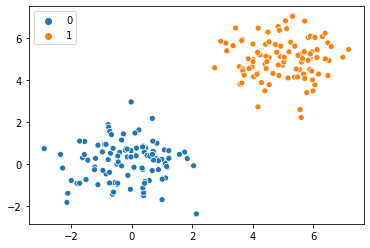

In [ ]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

1.0


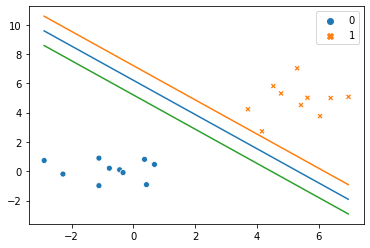

In [ ]:
lambd = 1e-9
pegab = PegasusSVMBiased(lambd)
pegab.fit(X_train, y_train, niter=100000)
yb = pegab.predict(X_test)
print(accuracy_score(y_test, yb))


line_x = np.arange(start=np.min(X_test[:,0]), stop=np.max(X_test[:,0]), step=0.01)

line_y = (-pegab.w[0] - pegab.w[1] * line_x) / pegab.w[2]
line_y_sup = (-pegab.w[0]/ pegab.w[2]) - ((pegab.w[1] * line_x) / pegab.w[2]) + 1
line_y_inf = (-pegab.w[0]/ pegab.w[2]) - ((pegab.w[1] * line_x) / pegab.w[2]) - 1

sns.lineplot(x=line_x, y=line_y)
sns.lineplot(x=line_x, y=line_y_sup)
sns.lineplot(x=line_x, y=line_y_inf)


#sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, style=yb)

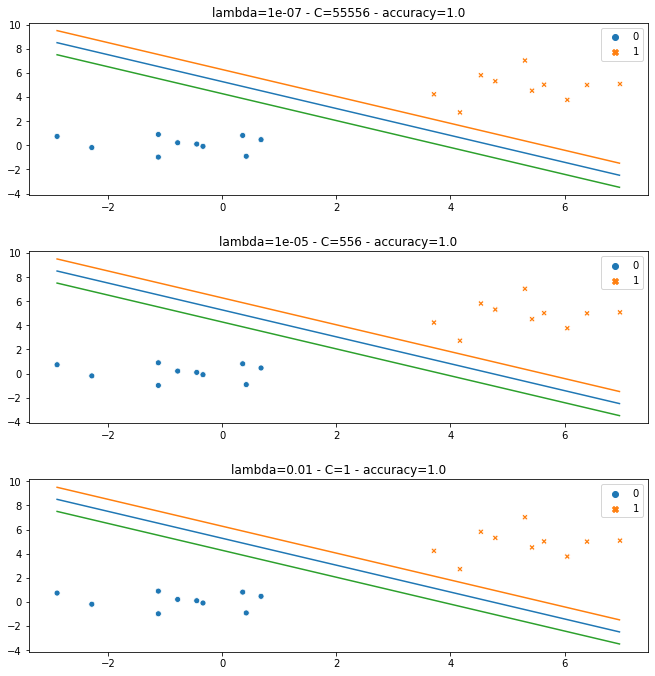

In [ ]:

def plot_solucion(lambd, n, X, y, predictions, w, accuracy, ax):
  ax.set_title("lambda={} - C={} - accuracy={}".format(lambd, round(lambda_to_C(lambd, n)), accuracy))
  line_x = np.arange(start=np.min(X[:,0]), stop=np.max(X[:,0]), step=0.01)

  line_y = (-w[0] - w[1] * line_x) / w[2]
  line_y_sup = (-w[0]/ w[2]) - ((w[1] * line_x) / w[2]) + 1
  line_y_inf = (-w[0]/ w[2]) - ((w[1] * line_x) / w[2]) - 1

  sns.lineplot(x=line_x, y=line_y, ax=ax)
  sns.lineplot(x=line_x, y=line_y_sup, ax=ax)
  sns.lineplot(x=line_x, y=line_y_inf, ax=ax)

  sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=predictions, ax=ax)
  #sns.scatterplot(x=X[:,0], y=X[:,1], hue=predictions, ax=ax)
   

lambdas = [1e-7, 1e-5, 1e-2]
ws = {}
accuracies = {}
predictions = {}
n = X_train.shape[0]

for lambd in lambdas:
  pegab = PegasusSVMBiased(lambd)
  #pegab = SVC(kernel="linear")
  pegab.fit(X_train, y_train, niter=100000)
  #pegab.fit(X_train, y_train)

  yb = pegab.predict(X_test)
  predictions[lambd] = yb
  accuracies[lambd] = accuracy_score(y_test, yb)
  #ws[lambd] = np.concatenate([pegab.intercept_, pegab.coef_[0]])
  ws[lambd] = pegab.w

    
fig, axes = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout(pad=3.5)

i = 0
for lambd in lambdas:
  plot_solucion(lambd, n, X_test, y_test, predictions[lambd], ws[lambd], accuracies[lambd], axes[i])

  i+=1
fig.show()

0.95


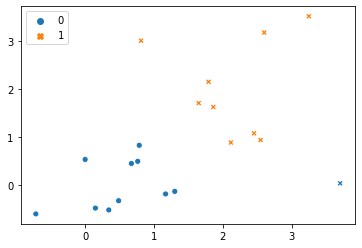

In [ ]:
# Ej 3
from sklearn.svm import SVC

separacion = 2 
X_train, X_test, y_train, y_test = load_gaussian_dataset(100, [0,0], [separacion, separacion], 1)
#sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train)

svc = SVC(kernel="rbf", gamma=1)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)

print(accuracy_score(y_test, predictions))
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions, style=y_test)

0.85


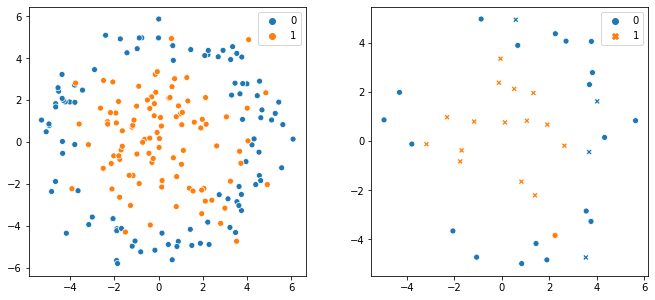

In [ ]:
radio = 5

def polares_a_punto(angulo, radio):
    return [radio*np.cos(angulo), radio*np.sin(angulo)]

def generar_puntos_en_anillo(cantidad, radio=5):
    angulos = np.random.uniform(0, 2*np.pi, cantidad)
    radios = np.random.normal(loc=radio, scale=radio/10, size=cantidad)
    return np.array([
        polares_a_punto(ang, rad)
        for (ang, rad) in zip(angulos, radios)
    ])

def generar_puntos_internos(cantidad, radio):
    return np.random.multivariate_normal(mean=[0,0], cov=radio * np.eye(2), size=cantidad)

cant_por_clase = 100
X0 = generar_puntos_en_anillo(cant_por_clase)
y0 = np.repeat(0, cant_por_clase)

X1 = generar_puntos_internos(cant_por_clase, 4)
y1 = np.repeat(1, cant_por_clase)

X = np.concatenate([X0, X1])
y = np.concatenate([y0, y1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout(pad=3.5)

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=ax[0])

svc = SVC(kernel="rbf", gamma=1)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)

print(accuracy_score(y_test, predictions))
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions, style=y_test, ax=ax[1])

c gamma score
[0.01, 0.1, 0.57]
[1, 0.1, 0.9]
[5, 0.1, 0.9]
[10, 0.1, 0.89]
[0.01, 0.001, 0.51]
[1, 0.001, 0.51]
[5, 0.001, 0.51]
[10, 0.001, 0.57]
[0.01, 1e-05, 0.5]
[1, 1e-05, 0.5]
[5, 1e-05, 0.5]
[10, 1e-05, 0.5]
0.9


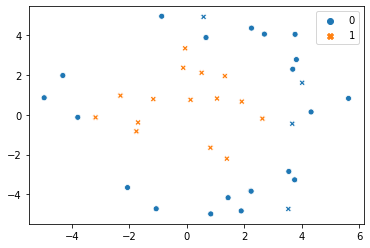

In [ ]:
from sklearn.model_selection import cross_val_score

cs = [0.01, 1, 5, 10]
gammas = [0.1, 0.001, 0.00001]
scores = []

for gamma in gammas:
  for c in cs:
    svc = SVC(kernel="rbf", C=c, gamma=gamma)
    mean_score = np.round(np.mean(cross_val_score(svc, X_train, y_train, cv=5, scoring="accuracy")), 2)
    scores.append([c, gamma, mean_score])


print("c gamma score")
print("\n".join([str(x) for x in scores]))

svc = SVC(kernel="rbf", C=1, gamma=0.1)
svc.fit(X_train, y_train)

predictions = svc.predict(X_test)

print(accuracy_score(y_test, predictions))
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=predictions, style=y_test)
